In [1]:
library(repr)
library(ggplot2)
library(gutenbergr)
options(jupyter.plot_mimetypes = 'image/png')

## [Professor IPNB](http://nbviewer.jupyter.org/format/slides/github/Velcin/)

# Parse the Gutemberg data base 

+ use the [gutemberger library](https://cran.r-project.org/web/packages/gutenbergr/README.html)
+ use the `grepl` command to filter the requiered data set

In [12]:
french_books = gutenberg_works(only_text=1, only_languages=1, languages="fr")
maupassant_books = french_books[grepl("Maupassant", french_books$author), ]
maupassant_books[c(1,2,3),]

gutenberg_id,title,author,gutenberg_author_id,language,gutenberg_bookshelf,rights,has_text
10746,Boule de Suif,"Maupassant, Guy de",306,fr,FR Nouvelles,Public domain in the USA.,TRUE
10775,Le Horla,"Maupassant, Guy de",306,fr,Gothic Fiction/FR Nouvelles,Public domain in the USA.,TRUE
11131,Pierre et Jean,"Maupassant, Guy de",306,fr,FR Littérature,Public domain in the USA.,TRUE


# Download the books
The result is a two column `tbl_df` dataframe from the `dplyr` library. It has one row per line of the text.
This dataframes are only a wrapper of the R dataframes to avoid long prints

In [39]:
if(FALSE){
    maupassant_downloaded_books <- gutenberg_download(maupassant_books$gutenberg_id)
    write.csv(maupassant_downloaded_books,"maupassant.csv")
    maupassant_downloaded_books[seq(76,85),]
}

# Load downloaded data 
+ To avoid problems with factors follow the [link](http://stackoverflow.com/questions/2851015/convert-data-frame-columns-from-factors-to-characters)
+ To convert between encoding [iconv](http://www.astrostatistics.psu.edu/datasets/R/html/utils/html/iconv.html)

In [64]:
maupassant_downloaded_books = read.table("maupassant.csv",sep=",",header=1, encoding="UTF-8",stringsAsFactors=F)

## Create corpus

In [51]:
library(NLP)
library(tm)

In [52]:
m.corpus <- Corpus(VectorSource(as.character(maupassant_downloaded_books$text)))
m.corpus

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 136214

In [53]:
attributes(m.corpus)
typeof(m.corpus)
excerpt = 100
m.corpus[[excerpt]]$content

$names
[1] "content" "meta"    "dmeta"  

$class
[1] "SimpleCorpus" "Corpus"

[1] "list"

[1] "ecus ou la longueur de leurs moustaches, couverts d'armes, de flanelle"

## Avoid encoding problems

In [54]:
m.corpus <- tm_map(m.corpus, function(x) iconv(enc2utf8(x), sub = "byte"))

## Lowering

In [55]:
m.corpus <- tm_map(m.corpus, content_transformer(tolower))
m.corpus[[excerpt]]$content

[1] "ecus ou la longueur de leurs moustaches, couverts d'armes, de flanelle"

## Remove punctuation and numbers

In [56]:
toSpace <- content_transformer(function (x , pattern) gsub(pattern, " ", x))
m.corpus <- tm_map(m.corpus, toSpace, "\'")
m.corpus <- tm_map(m.corpus, removeNumbers)
m.corpus <- tm_map(m.corpus, removePunctuation)
m.corpus[[excerpt]]$content

[1] "ecus ou la longueur de leurs moustaches couverts d armes de flanelle"

## Words - Documents Matrix

In [57]:
m.dtm <- TermDocumentMatrix(m.corpus)
inspect(m.dtm)

<<TermDocumentMatrix (terms: 40614, documents: 136214)>>
Non-/sparse entries: 711470/5531483926
Sparsity           : 100%
Maximal term length: 42
Weighting          : term frequency (tf)
Sample             :
      Docs
Terms  10112 10558 11344 15287 27505 39126 57442 60275 6715 8851
  dans     0     0     0     0     0     0     0     1    0    1
  des      0     0     0     1     0     0     2     0    0    0
  elle     0     0     0     0     0     0     0     0    0    0
  les      1     1     0     0     0     0     0     3    1    1
  pas      0     0     0     0     0     0     0     0    1    0
  que      0     1     2     0     0     0     2     0    0    0
  qui      1     2     0     0     2     1     0     0    0    0
  son      0     0     2     1     2     0     2     0    0    0
  sur      0     0     0     0     0     0     0     0    1    0
  une      2     0     0     1     0     0     0     0    1    0


In [58]:
excerpt <- 100
q <- m.dtm[,excerpt]
q <- as.vector(q)
lignes.non.vides <- which(q > 0)
inspect(m.dtm[lignes.non.vides,excerpt])

<<TermDocumentMatrix (terms: 7, documents: 1)>>
Non-/sparse entries: 7/0
Sparsity           : 0%
Maximal term length: 10
Weighting          : term frequency (tf)
Sample             :
            Docs
Terms        100
  armes        1
  couverts     1
  ecus         1
  flanelle     1
  leurs        1
  longueur     1
  moustaches   1


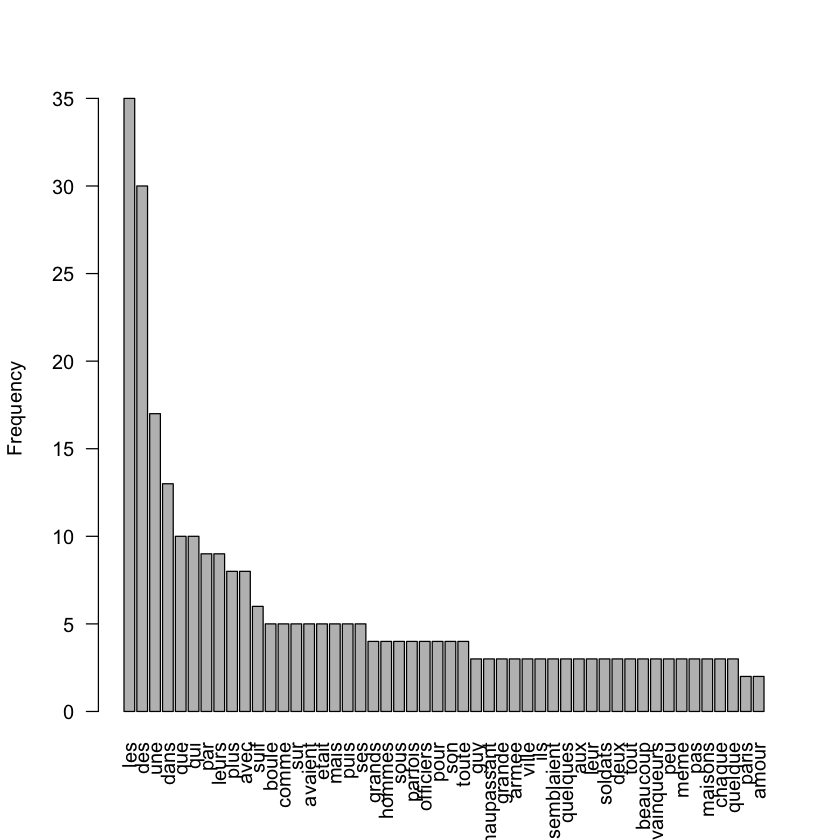

In [59]:
m <- as.matrix(m.dtm[1:1000,1:200])
m.freq <- rowSums(m)
m.freq.sorted <- sort(m.freq, decreasing=TRUE)
barplot(m.freq.sorted[1:50], ylab="Frequency", las=2)

# Stop words

In [60]:
stopwords("french")
#french_stopwords <- c(stopwords("french"), "blablabla")

[1] "au"       "aux"      "avec"     "ce"       "ces"      "dans"    
  [7] "de"       "des"      "du"       "elle"     "en"       "et"      
 [13] "eux"      "il"       "je"       "la"       "le"       "leur"    
 [19] "lui"      "ma"       "mais"     "me"       "même"     "mes"     
 [25] "moi"      "mon"      "ne"       "nos"      "notre"    "nous"    
 [31] "on"       "ou"       "par"      "pas"      "pour"     "qu"      
 [37] "que"      "qui"      "sa"       "se"       "ses"      "son"     
 [43] "sur"      "ta"       "te"       "tes"      "toi"      "ton"     
 [49] "tu"       "un"       "une"      "vos"      "votre"    "vous"    
 [55] "c"        "d"        "j"        "l"        "à"        "m"       
 [61] "n"        "s"        "t"        "y"        "été"      "étée"    
 [67] "étées"    "étés"     "étant"    "suis"     "es"       "est"     
 [73] "sommes"   "êtes"     "sont"     "serai"    "seras"    "sera"    
 [79] "serons"   "serez"    "seront"   "serais"   "serait"   "serions" 
 [85] "seriez"   "seraient" "étais"    "était"    "étions"   "étiez"   
 [91] "étaient"  "fus"      "fut"      "fûmes"    "fûtes"    "furent"  
 [97] "sois"     "soit"     "soyons"   "soyez"    "soient"   "fusse"   
[103] "fusses"   "fût"      "fussions" "fussiez"  "fussent"  "ayant"   
[109] "eu"       "eue"      "eues"     "eus"      "ai"       "as"      
[115] "avons"    "avez"     "ont"      "aurai"    "auras"    "aura"    
[121] "aurons"   "aurez"    "auront"   "aurais"   "aurait"   "aurions" 
[127] "auriez"   "auraient" "avais"    "avait"    "avions"   "aviez"   
[133] "avaient"  "eut"      "eûmes"    "eûtes"    "eurent"   "aie"     
[139] "aies"     "ait"      "ayons"    "ayez"     "aient"    "eusse"   
[145] "eusses"   "eût"      "eussions" "eussiez"  "eussent"  "ceci"    
[151] "cela"     "celà"     "cet"      "cette"    "ici"      "ils"     
[157] "les"      "leurs"    "quel"     "quels"    "quelle"   "quelles" 
[163] "sans"     "soi"

In [61]:
m.corpus.sw <- tm_map(m.corpus, removeWords, stopwords('french'))

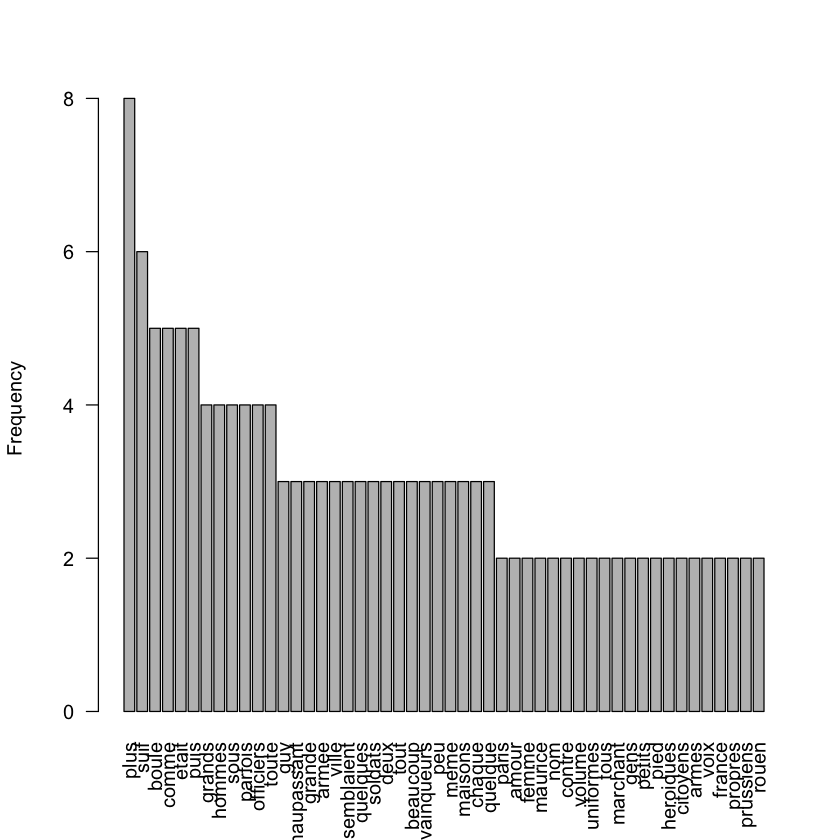

In [62]:
m.dtm.sw <- TermDocumentMatrix(m.corpus.sw)
m <- as.matrix(m.dtm.sw[1:1000,1:200])
m.freq <- rowSums(m)
m.freq.sorted <- sort(m.freq, decreasing=TRUE)
barplot(m.freq.sorted[1:50], ylab="Frequency", las=2)

## Remove sparse terms

In [63]:
m.corpus.sw.lw <-removeSparseTerms(m.dtm.sw, 0.9998) 
inspect(m.dtm.sw.lw)

ERROR: Error in inspect(m.dtm.sw.lw): objet 'm.dtm.sw.lw' introuvable


## Steming

In [64]:
library(SnowballC)
m.corpus.stemmed <- tm_map(m.corpus.sw, stemDocument, language="french")

# Visualization

In [65]:
library(slam)
m.dtm.sw.sum <- rollup(m.dtm.sw, 2, na.rm=TRUE, FUN = sum)

## Wordcloud

Loading required package: wordcloud


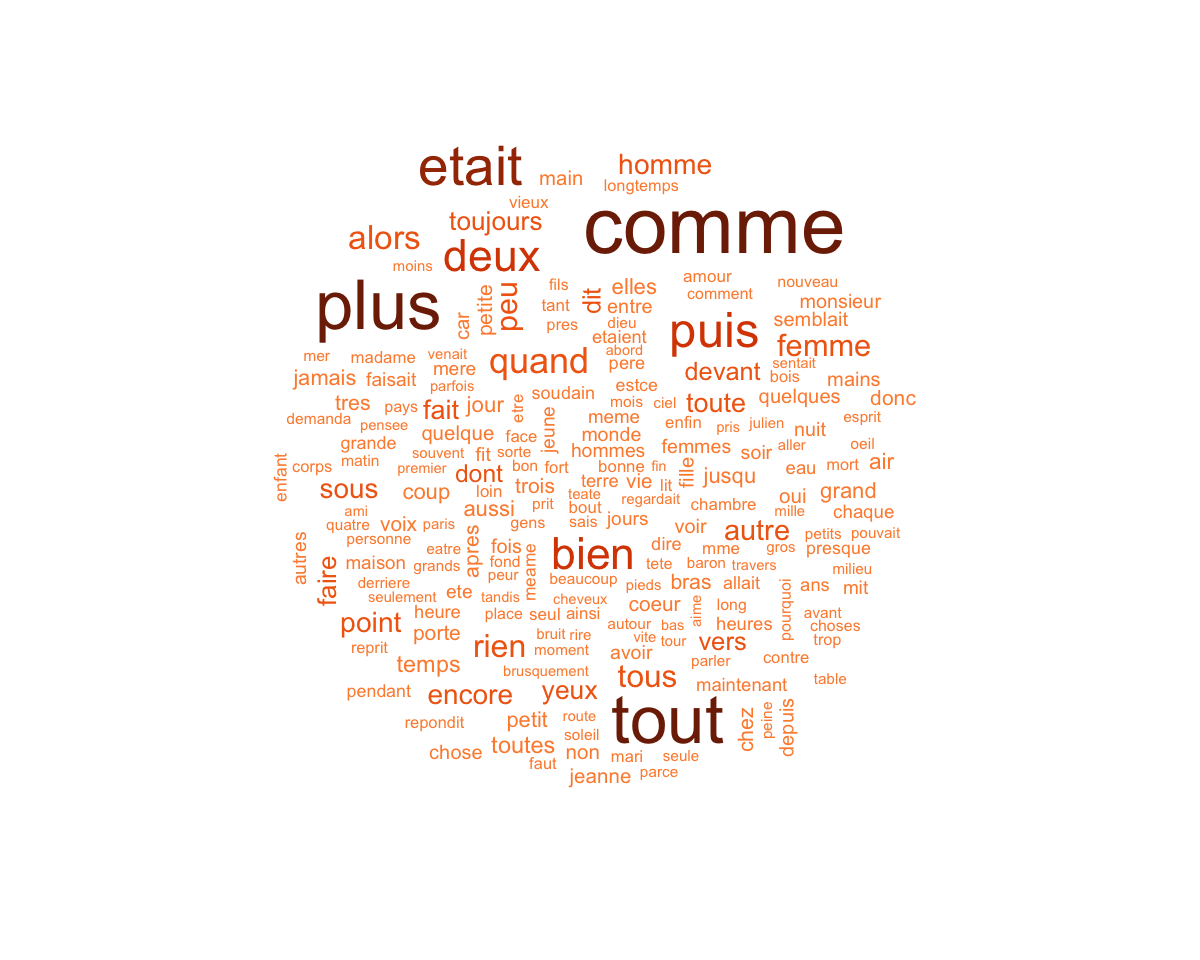

In [66]:
options(warn=-1)
options(repr.plot.width=10, repr.plot.height=8)
library(Rcpp)
library(RColorBrewer)
require(wordcloud)
pal <- brewer.pal(9,"Oranges")
pal <- pal[-(1:4)]
wordcloud(as.vector(m.dtm.sw.sum$dimnames$Terms), as.vector(m.dtm.sw.sum), max.words=200, colors=pal)

## Concordancer

In [67]:
concord <- function(word,window,wholetxt){
  occ <- gregexpr(word, wholetxt)[[1]]
  context.left <- sapply(occ, function(x) substring(wholetxt, x-window, x-1))
  context.right <- sapply(occ, function(x) substring(wholetxt, x+nchar(word), x+nchar(word)+window))
  return(data.frame(context.left, word, context.right))
}

In [68]:
m <- paste(as.character(maupassant_downloaded_books$text),collapse='')
concordance_df <- concord("folle",20,m)
concordance_df[10:20,]

,context.left,word,context.right
10,"une joie, une joie",folle,m'asaisi. Je me suis
11,"x, lesetranges feux",folle,"ts, le silence profon"
12,isprise d'une envie,folle,de le leur faire ce
13,ue j'allais devenir,folle,. Oh! quelle peur! So
14,"butiai, tout a fait",folle,": ""Allez-vous-en, Mon"
15,"a rire, mais a rire",folle,"ment,la tete dans l'o"
16,"it envie, une envie",folle,de prendrepar le cou
17,"es, tout ca me rend",folle,! C'est comme lechamp
18,"epetait: ""Mais tu es",folle,". Mais tu es folle, c"
19,esfolle. Mais tu es,folle,", ce matin. Qu'est-ce"


# Cosine similarity

In [69]:
cosine = function(x,y){
    x <- as.simple_triplet_matrix(x)
    y <- as.simple_triplet_matrix(y)
    x.norm <- crossprod_simple_triplet_matrix(x,x)
    y.norm <- crossprod_simple_triplet_matrix(y,y)
    scalar.x.y <- crossprod_simple_triplet_matrix(x,y)
    return(scalar.x.y/(x.norm*y.norm))
}

# TFxIDF

In [70]:
m.dtm.sw.stemmed.tfxidf <- TermDocumentMatrix(m.corpus.stemmed, control = list(weighting=weightTfIdf))
inspect(m.dtm.sw.stemmed.tfxidf[1:10,1:10])
findFreqTerms(m.dtm.sw.stemmed.tfxidf)[1:10]

<<TermDocumentMatrix (terms: 10, documents: 10)>>
Non-/sparse entries: 10/90
Sparsity           : 90%
Maximal term length: 10
Weighting          : term frequency - inverse document frequency (normalized) (tf-idf)
Sample             :
            Docs
Terms               1 10 2 3 4 5        6 7        8 9
  antin      0.000000  0 0 0 0 0 2.894111 0 0.000000 0
  boul       3.378884  0 0 0 0 0 0.000000 0 0.000000 0
  chausse    0.000000  0 0 0 0 0 2.561518 0 0.000000 0
  collect    0.000000  0 0 0 0 0 0.000000 0 4.269196 0
  grand      0.000000  0 0 0 0 0 0.000000 0 1.930553 0
  illustr    3.526594  0 0 0 0 0 0.000000 0 0.000000 0
  librair    0.000000  0 0 0 0 0 2.746717 0 0.000000 0
  ollendorff 0.000000  0 0 0 0 0 2.777118 0 0.000000 0
  paris      0.000000  0 0 0 0 0 1.677326 0 0.000000 0
  suif       3.475386  0 0 0 0 0 0.000000 0 0.000000 0


[1] "boul"       "illustr"    "suif"       "antin"      "chausse"   
 [6] "librair"    "ollendorff" "paris"      "collect"    "grand"

# Simple Search Engine

## Create the query vector

In [71]:
create.query = function(query,vocab.corpus){
    query.vec <- rep(0,length(vocab.corpus))
    for (w in match(query, vocab.corpus)){
        query.vec[w] <- query.vec[w] + 1
    }
    query.vec <- as.simple_sparse_array(query.vec)
    return(query.vec)
}

In [72]:
vocab.corpus <- as.vector(m.dtm.sw.stemmed.tfxidf$dimnames$Terms)
query <- c("paris","boul")
query.vec <- create.query(query,vocab.corpus)

## Execute query using the cosine measure
Operations in sparese matrices with the slam [package](https://cran.r-project.org/web/packages/slam/slam.pdf)

In [73]:
m.dtm.sw.stemmed.tfxidf.3mat <- as.simple_triplet_matrix(m.dtm.sw.stemmed.tfxidf)
query.vec.3mat <- as.simple_triplet_matrix(query.vec)
rank <- colapply_simple_triplet_matrix(m.dtm.sw.stemmed.tfxidf.3mat,function(x) cosine(x,query.vec.3mat))

In [74]:
top.docs <- sort(rank, decreasing=TRUE)[1:10]
top.docs
maupassant_downloaded_books[names(top.docs),]

124303      86319      86262       5274      83316       1211      98762 
0.08856295 0.08307144 0.07970478 0.07962648 0.07890164 0.07662381 0.07662381 
     64764      39286     124994 
0.07659045 0.07453662 0.07346679

,X,gutenberg_id,text
124303,124303,50144,à tout le monde; et les dames de Paris vous regarderaient comme une
86319,86319,18353,"fille!... Et Paris, ce grand Paris sombre, morne, boueux, triste, noir,"
86262,86262,18353,hommes Paris.
5274,5274,10775,Je vais partir tout a l'heure pour Paris.
83316,83316,17457,monde; et les dames de Paris vous regarderaient comme une
1211,1211,10746,"l'officier de garder Boule de Suif toute seule, et de laisser partir"
98762,98762,45119,"l'officier de garder Boule de Suif toute seule, et de laisser partir les"
64764,64764,14790,"C'tait leur tour, eux, de manger des boules."
39286,39286,11495,"--L'autre etait a Paris! Enfin, pendant six semaines, c'a ete tres bien"
124994,124994,50144,Elle partit pour Paris la nuit même.


# Suffix Array

In [1]:
library("gdata")

In [21]:
common.prefix <- function(word1, word2){
    s1 <- substring(word1, 1, 1:nchar(word1))
    s2 <- substring(word2, 1, 1:nchar(word2))
    w <- which(s1 %in% s2)
    prefix <- ""
    if(length(w)){
        prefix <- s2[max(w)]
    }
    else{
        prefix <- character(1)
    }
    return(prefix)
}

In [22]:
count.common <- function(common)
{
  output <- data.frame(motif=character(), freq=integer())
  i <- 2
  while (i <= nchar(ch))
  {
    current <- trim(common[i])
    k <- -1
    if ((current != "") && (length(output$motif[output$motif == current]) == 0))
    {
      sum <- 1
      j <- i - 1
      # backward
      while ((j>1) && (substring(common[j], 1, nchar(current)) == current))
      {
        sum <- sum + 1
        j <- j - 1
      }
      # forward
      j <- i + 1
      while ((j<=nchar(ch)) && (substring(common[j], 1, nchar(current)) == current))
      {
        if ((common[j] != current) && (k == -1))  k <- j
        sum <- sum + 1
        j <- j + 1
      }
      output <- rbind(output, data.frame(motif = current, freq = sum + 1))
    }
    if (k != -1)
    {
      i <- k
    }    
    else
      i <- i + 1
  }
  return(output[order(as.character(output$motif)),])
} 

In [13]:
# main function that extracts the frequent motifs
build.freq.motifs <- function(ch)
{
  tab <- data.frame(cbind(1:nchar(ch), sapply(1:nchar(ch), function(x) substring(ch, x, nchar(ch)))))
  colnames(tab) <- c("index", "suffix")
  tab <- tab[order(tab$suffix),]
  common.p <- c("", sapply(2:nchar(ch), function(i) common.prefix(as.character(tab$suffix[i]), as.character(tab$suffix[i-1]))))
  tab <- cbind(tab, common.p)
  return (count.common(common.p))
}


In [41]:
reverse <- function(ch)
{
    return(paste(strsplit(ch, "")[[1]][nchar(ch):1], collapse=""))
}

In [35]:
maupassant.test <- as.character(maupassant_downloaded_books$text)[100:120]
ch <- tolower(gsub("[^[:alpha:]]", " ", paste(maupassant.test, collapse="")))
ch <- gsub(" ", "_", ch)
rbind(1:nchar(ch),strsplit(ch, "")[[1]])

1,2,3,4,5,6,7,8,9,10,⋯,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114
e,c,u,s,_,o,u,_,l,a,⋯,l,e,_,h,a,b,i,t,u,e


In [37]:
tab <- data.frame(cbind(1:nchar(ch), sapply(1:nchar(ch), function(x) substring(ch, x, nchar(ch)))))
colnames(tab) <- c("index", "suffix")
tab <- tab[order(tab$suffix),]
common.p <- c("", sapply(2:nchar(ch), function(i) common.prefix(as.character(tab$suffix[i]), as.character(tab$suffix[i-1]))))
head(cbind(tab, common.p, LCP=nchar(common.p), row.names=NULL))


index,suffix,common.p,LCP
808,__avaientsubitement_disparu_les_derniers_soldats_francais_venaient_enfin_de_traverser_la_seine_pourgagner_pont_audemer_par_saint_sever_et_bourg_achard__et__marchant_aprestous__le_general__desespere__ne_pouvant_rien_tenter_avec_ces_loquesdisparates__eperdu_lui_meme_dans_la_grande_debacle_d_un_peuple_habitue,,0
40,__couverts_d_armes__de_flanelleet_de_galons__parlaient_d_une_voix_retentissante__discutaient_plans_decampagne__et_pretendaient_soutenir_seuls_la_france_agonisante_surleurs_epaules_de_fanfarons__mais_ils_redoutaient_parfois_leurs_propressoldats__gens_de_sac_et_de_corde__souvent_braves_a_outrance__pillards_etdebauches_les_prussiens_allaient_entrer_dans_rouen__disait_on_la_garde_nationale_qui__depuis_deux_mois__faisait_des_reconnaissancestres_prudentes_dans_les_bois_voisins__fusillant_parfois_ses_propressentinelles__et_se_preparant_au_combat_quand_un_petit_lapin_remuaitsous_des_broussailles__etait_rentree_dans_ses_foyers__ses_armes__sesuniformes__tout_son_attirail_meurtrier__dont_elle_epouvantait_naguereles_bornes_des_routes_nationales_a_trois_lieues_a_la_ronde__avaientsubitement_disparu_les_derniers_soldats_francais_venaient_enfin_de_traverser_la_seine_pourgagner_pont_audemer_par_saint_sever_et_bourg_achard__et__marchant_aprestous__le_general__desespere__ne_pouvant_rien_tenter_avec_ces_loquesdisparates__eperdu_lui_meme_dans_la_grande_debacle_d_un_peuple_habitue,__,2
58,__de_flanelleet_de_galons__parlaient_d_une_voix_retentissante__discutaient_plans_decampagne__et_pretendaient_soutenir_seuls_la_france_agonisante_surleurs_epaules_de_fanfarons__mais_ils_redoutaient_parfois_leurs_propressoldats__gens_de_sac_et_de_corde__souvent_braves_a_outrance__pillards_etdebauches_les_prussiens_allaient_entrer_dans_rouen__disait_on_la_garde_nationale_qui__depuis_deux_mois__faisait_des_reconnaissancestres_prudentes_dans_les_bois_voisins__fusillant_parfois_ses_propressentinelles__et_se_preparant_au_combat_quand_un_petit_lapin_remuaitsous_des_broussailles__etait_rentree_dans_ses_foyers__ses_armes__sesuniformes__tout_son_attirail_meurtrier__dont_elle_epouvantait_naguereles_bornes_des_routes_nationales_a_trois_lieues_a_la_ronde__avaientsubitement_disparu_les_derniers_soldats_francais_venaient_enfin_de_traverser_la_seine_pourgagner_pont_audemer_par_saint_sever_et_bourg_achard__et__marchant_aprestous__le_general__desespere__ne_pouvant_rien_tenter_avec_ces_loquesdisparates__eperdu_lui_meme_dans_la_grande_debacle_d_un_peuple_habitue,__,2
432,__depuis_deux_mois__faisait_des_reconnaissancestres_prudentes_dans_les_bois_voisins__fusillant_parfois_ses_propressentinelles__et_se_preparant_au_combat_quand_un_petit_lapin_remuaitsous_des_broussailles__etait_rentree_dans_ses_foyers__ses_armes__sesuniformes__tout_son_attirail_meurtrier__dont_elle_epouvantait_naguereles_bornes_des_routes_nationales_a_trois_lieues_a_la_ronde__avaientsubitement_disparu_les_derniers_soldats_francais_venaient_enfin_de_traverser_la_seine_pourgagner_pont_audemer_par_saint_sever_et_bourg_achard__et__marchant_aprestous__le_general__desespere__ne_pouvant_rien_tenter_avec_ces_loquesdisparates__eperdu_lui_meme_dans_la_grande_debacle_d_un_peuple_habitue,__de,4
994,__desespere__ne_pouvant_rien_tenter_avec_ces_loquesdisparates__eperdu_lui_meme_dans_la_grande_debacle_d_un_peuple_habitue,__de,4
398,__disait_on_la_garde_nationale_qui__depuis_deux_mois__faisait_des_reconnaissancestres_prudentes_dans_les_bois_voisins__fusillant_parfois_ses_propressentinelles__et_se_preparant_au_combat_quand_un_petit_lapin_remuaitsous_des_broussailles__etait_rentree_dans_ses_foyers__ses_armes__sesuniformes__tout_son_attirail_meurtrier__dont_elle_epouvantait_naguereles_bornes_des_routes_nationales_a_trois_lieues_a_la_ronde__avaientsubitement_disparu_les_derniers_soldats_francais_venaient_enfin_de_traverser_la_seine_pourgagner_pont_audemer_par_saint_sever_et_bourg_achard__et__marchant_aprestous__le_general__desespere__ne_pouvant_rien_tenter_avec_ces_loquesdisparates__eperdu_lui_meme_da

In [39]:
message("Right complete substrings, computed in O(n):")
head(build.freq.motifs(ch))

Right complete substrings, computed in O(n):


,motif,freq
13,_,186
1,__,26
3,__d,6
2,__de,3
4,__dis,2
5,__e,5


In [44]:
message("Reverse string:")
ch.rev <- print(reverse(ch))

Reverse string:


[1] "eutibah_elpuep_nu_d_elcabed_ednarg_al_snad_emem_iul_udrepe__setarapsidseuqol_sec_ceva_retnet_neir_tnavuop_en__erepsesed__lareneg_el__suotserpa_tnahcram__te__drahca_gruob_te_reves_tnias_rap_remedua_tnop_rengagruop_enies_al_resrevart_ed_nifne_tneianev_siacnarf_stadlos_sreinred_sel_urapsid_tnemetibustneiava__ednor_al_a_seueil_siort_a_selanoitan_setuor_sed_senrob_selereugan_tiatnavuope_elle_tnod__reirtruem_liaritta_nos_tuot__semrofinuses__semra_ses__sreyof_ses_snad_eertner_tiate__selliassuorb_sed_suostiaumer_nipal_titep_nu_dnauq_tabmoc_ua_tnaraperp_es_te__sellenitnesserporp_ses_siofrap_tnallisuf__snisiov_siob_sel_snad_setnedurp_sertsecnassiannocer_sed_tiasiaf__siom_xued_siuped__iuq_elanoitan_edrag_al_no_tiasid__neuor_snad_rertne_tneialla_sneissurp_sel_sehcuabedte_sdrallip__ecnartuo_a_sevarb_tnevuos__edroc_ed_te_cas_ed_sneg__stadlosserporp_sruel_siofrap_tneiatuoder_sli_siam__snorafnaf_ed_seluape_sruelrus_etnasinoga_ecnarf_al_slues_rinetuos_tneiadneterp_te__engapmaced_snalp_tneiatucsid_

In [50]:
message("Left complete substrings, computed in O(n):")
leftcomplete <- build.freq.motifs(ch.rev)
motifs.rev <- sapply(as.character(leftcomplete$motif), reverse)
leftcomplete.rev <- data.frame(motif=motifs.rev, freq= leftcomplete$freq, row.names=NULL)

Left complete substrings, computed in O(n):


In [48]:
message("Right complete substrings:")
head(rightcomplete)
message("Left complete substrings:")
head(leftcomplete.rev)
message("Intersection (freq in descreasing order):")
motifs.inter <- intersect(rightcomplete$motif, leftcomplete.rev$motif)
freq.inter <- subset(rightcomplete, motif %in% motifs.inter)
head(freq.inter[order(freq.inter$freq, decreasing = TRUE),])


Right complete substrings:


,motif,freq
13,_,186
1,__,26
3,__d,6
2,__de,3
4,__dis,2
5,__e,5


Left complete substrings:


motif,freq
_,186
__,26
e__,6
de__,2
s__,14
es__,7


Intersection (freq in descreasing order):


,motif,freq
13,_,186
170,e,148
434,s,104
95,a,94
299,n,75
379,r,73


In [49]:
message("Removing too small strings:")
motifs.inter <- motifs.inter[nchar(motifs.inter)>2]
freq.inter <- subset(rightcomplete, motif %in% motifs.inter)
head(data.frame(freq.inter[order(freq.inter$freq, decreasing = TRUE),], row.names=NULL))


Removing too small strings:


motif,freq
es_,27
_de,16
ent,15
nt_,15
s__,14
de_,11


# Pointwise Mutual Information

In [ ]:
m.dtm.sw.stemmed <- TermDocumentMatrix(m.corpus.stemmed)
inspect(m.dtm.sw.stemmed)

In [ ]:
m.dtm.sw.stemmed.3mat <- as.simple_triplet_matrix(m.dtm.sw.stemmed["autr",])
rank <- rowapply_simple_triplet_matrix(m.dtm.sw.stemmed.tfxidf.3mat,function(x) x >0)

In [89]:
head(rank)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


# [Tagging](https://cran.r-project.org/web/packages/wordnet/wordnet.pdf)

In [65]:
library(koRpus)

In [160]:
maupassant_downloaded_books = read.table("maupassant.csv",sep=",",header=1, encoding="UTF-8",stringsAsFactors=F)
maupassant_downloaded_books[3][maupassant_downloaded_books[3] == ""] = '_'
maupassant_full_text  <- paste(as.character(maupassant_downloaded_books[,3]),collapse = ' ')
maupassant_full_text  <-unlist(strsplit(maupassant_full_text,"_ "))
maupassant_full_text <- maupassant_full_text[maupassant_full_text != '']
write.csv(maupassant_full_text[20:10000],"maupassant_texte_pure_test.txt",row.names = FALSE, col.names = FALSE,quote=FALSE)

Warning message in write.csv(maupassant_full_text[20:10000], "maupassant_texte_pure_test.txt", :
“attempt to set 'col.names' ignored”

In [152]:
length(maupassant_full_text)
maupassant_full_text[length(maupassant_full_text)]
#maupassant_full_text[3000:length(maupassant_full_text)]
#iconv(x, from, to,

[1] 32019

[1] "  Page 232: «marinière» remplacé par «marnière» (avait jeté son enfant               dans une marnière!)"

In [163]:
tagged.text <- treetag("maupassant_texte_pure_test.txt", treetagger="manual",
    lang="fr", TT.options=list(path="~/Documents/tree-tagger-MacOSX-3.2", preset="fr"))

In [164]:
taggedText(tagged.text)

token,tag,lemma,lttr,wclass,desc,stop,stem
BOULE,NOM,boule,5,noun,noun,NA,NA
DE,NAM,<unknown>,2,name,proper name,NA,NA
SUIF,NAM,<unknown>,4,name,proper name,NA,NA
Pendant,NAM,<unknown>,7,name,proper name,NA,NA
plusieurs,PRO:IND,plusieurs,9,pronoun,indefinite pronoun,NA,NA
jours,NOM,jour,5,noun,noun,NA,NA
de,PRP,de,2,preposition,preposition,NA,NA
suite,NOM,suite,5,noun,noun,NA,NA
des,PRP:det,du,3,preposition,"preposition plus article (au,du,aux,des)",NA,NA
lambeaux,NOM,lambeau,8,noun,noun,NA,NA


# [Wordnet](https://cran.r-project.org/web/packages/wordnet/wordnet.pdf)

In [165]:
library(wordnet)

Warning message in initDict():
“cannot find WordNet 'dict' directory: please set the environment variable WNHOME to its parent”

In [171]:
setDict("/Users/peigniersergio/Documents/WordNet-3.0/dict")

In [169]:
getDict()


[1] "Java-Object{com.nexagis.jawbone.Dictionary@1d44bcfa}"

In [172]:
filter <- getTermFilter("StartsWithFilter", "car", TRUE)
getIndexTerms("NOUN", 5, filter)

[[1]]
[1] "Java-Object{Lemma: car  POS: noun  Tag-Sense-Count: 2\nList of Synsets (5)\n  #1: 2958343\n  #2: 2959942\n  #3: 2960501\n  #4: 2960352\n  #5: 2934451\nList of Pointers (6)\n  #1: @ (Hypernym)\n  #2: ~ (Hyponym)\n  #3: #m (Member holonym)\n  #4: #p (Part holonym)\n  #5: %p (Part meronym)\n  #6: - ([Unknown])}"

[[2]]
[1] "Java-Object{Lemma: car-ferry  POS: noun  Tag-Sense-Count: 0\nList of Synsets (1)\n  #1: 2964295\nList of Pointers (1)\n  #1: @ (Hypernym)}"

[[3]]
[1] "Java-Object{Lemma: car-mechanic  POS: noun  Tag-Sense-Count: 0\nList of Synsets (1)\n  #1: 9825750\nList of Pointers (1)\n  #1: @ (Hypernym)}"

[[4]]
[1] "Java-Object{Lemma: car battery  POS: noun  Tag-Sense-Count: 0\nList of Synsets (1)\n  #1: 2961225\nList of Pointers (2)\n  #1: @ (Hypernym)\n  #2: #p (Part holonym)}"

[[5]]
[1] "Java-Object{Lemma: car bomb  POS: noun  Tag-Sense-Count: 0\nList of Synsets (1)\n  #1: 2961544\nList of Pointers (1)\n  #1: @ (Hypernym)}"


In [174]:
getFilterTypes()

[1] "ContainsFilter"   "EndsWithFilter"   "ExactMatchFilter" "RegexFilter"     
[5] "SoundFilter"      "StartsWithFilter" "WildcardFilter"

In [175]:
? getTermFilter

# Topic Modeling

## See the other notebook